# Ridge Regression

**Prerequisites**

- Linear Algebra
- Linear Models
- Overfitting and Model Selection


**Outcomes**

- Understand how ridge regression is a regularized version of linear regression
- Learn how ridge regression utilizes the input data's Gram matrix
- Be able to apply ridge regression using sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from ipywidgets import widgets

from sklearn import pipeline, linear_model, preprocessing, model_selection, metrics

%matplotlib inline
plt.style.use("seaborn")

## What is Ridge Regression?

-   **Ridge Regression** is linear regression with an $L_2$-norm regularization
-   This particular regularizer is conducive in obtaining a closed-form solution for the optimal weights 

$$\begin{aligned}
\theta_{\mu}^* & \triangleq \arg \min_{\theta} \bigg [ \frac{1}{N} \| y - X \theta  \|_2^2 + \frac{\mu}{N}  \| \theta  \|_2^2 \bigg ] \\
            & = \arg \min_{\theta} \frac{1}{N} \bigg [ \| y \|_2^2 - 2 \theta^T X^T y + \theta^T \big ( X^T X + \mu I_P  \big ) \theta \bigg ] \\
            & = \big ( X^T X + \mu I_P \big )^{-1} X^T y
\end{aligned}$$

### Comments

$$\theta_{\mu}^* = \big ( \underbrace{X^T X}_{R} + \mu I_P \big )^{-1} X^T y$$

- Even when $R$ is not invertiable (e.g. when $P \ge N$), $R + \mu I_P$ always is when $\mu > 0$
- Finding the best $\mu$ value $\Longleftrightarrow$ selecting the best ridge regression model
- $\mu$ is hyperparameter $\Longrightarrow$ optimal $\mu$ chosen via validation procedure

## Example: Polynomial Regression

Recall our polynomial regression example

Let's see what it looks like when we add and L2 regularization (i.e. use Ridge regression)

In [2]:
loaded = np.load('polyreg_demo_data.npz')

x = loaded['x']
y = loaded['y']
x_plot = loaded['x_plot']
y_hat_plot_true = loaded['y_hat_plot']
theta_true = loaded['theta_true']
sigma = loaded['sigma'].item()
N_total = x.shape[0]        # retrieve the total number of samples in the dataset

In [3]:
def polyreg_ridge_ridgedemo(degree=8, n_train=8, mu=0):
    # define model
    model = pipeline.make_pipeline(
        preprocessing.PolynomialFeatures(degree=degree),
        linear_model.Ridge(alpha=mu)
    )
    
    X = x[:, None]  # convert to 2d
    test_size = X.shape[0] - n_train
    split = model_selection.train_test_split(X, y, train_size=n_train, test_size=test_size, random_state=42)
    X_train, X_test, y_train, y_test = split
   
    # fit model
    model.fit(X_train, y_train)
    yhat = model.predict(x_plot[:, None])
    
    # compute metrics
    MSE_train = metrics.mean_squared_error(y_train, model.predict(X_train))
    MSE_holdout = metrics.mean_squared_error(y_test, model.predict(X_test))

    # make the plot
    fig = plt.figure('demo', figsize=(11, 8))
    plt.plot(x_plot, yhat, "k-", lw=3, label="Fitted Model")
    plt.scatter(X_test.flatten(), y_test, color="b", s=60, alpha=0.5, label="Hold-Out Data")
    plt.scatter(X_train.flatten(), y_train, color="r", s=80, alpha=0.7, label="Training Data") 
    plt.ylim(-20, 20)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper left')
    titletxt = 'Fitted vs. True Model Responses: mu = {} Ntrain={} deg={} MSEtrain={:.3f}, MSEholdout={:.3f}, NoiseVar={:.3f}'
    plt.title(titletxt.format(mu, n_train, degree, MSE_train, MSE_holdout, sigma))
    
    return fig


widgets.interactive(
    polyreg_ridge_ridgedemo, 
    degree=(1, 10, 1), 
    n_train=(1, 35, 1),
    mu=(0, 10.0)
)

interactive(children=(IntSlider(value=8, description='degree', max=10, min=1), IntSlider(value=8, description=…

## Gram Matrix

- Definition: for a collection of $N$ vectors $\{X_n \}_{n=1}^N$ their Gram matrix $G$ is defined as the matrix containing all possible dot products between them:
$$G \triangleq XX^T = \begin{bmatrix}
x_1^Tx_1 & x_1^Tx_2 & \cdots \\
x_2^Tx_1 & x_2^Tx_2 & \cdots \\
\dots & \dots & \ddots
\end{bmatrix} \in \mathbb{R}^{N\times N}$$
- Symmetry: the dot product is symmetric in its arguments, therefore $G$ is symmetric

### Ridge Regression via Gram Matrix

- For suitable matrices (conformable and invertible as needed), the following holds:
$$\big(A + B^TCB \big)^{-1} = A^{-1}B^T (B A^{-1}B^T + C^{-1})^{-1}$$
- When applied to $(R + \mu I_P)^{-1} = (X^TX + \mu I_P)^{-1}$ for $\mu > 0$ one obtains: $$(R + \mu I_P)^{-1} = X^T (G + \mu I_N)^{-1}$$
- Therefore: $$\theta_{\mu}^* = X^T (G + \mu I_N)^{-1} y$$

## Ridge Regression by Hand

Let's use this theory to compute ridge regression "by hand"

We know that we can find $\theta$ via the Gram matrix: $$\theta_{\mu}^* = X^T (G + \mu I_N)^{-1} y$$

We also know we can find it directly: $$\theta_{\mu}^* = \big ( X^T X + \mu I_P \big )^{-1} X^T y$$

We'll show both approaches below

In [4]:
n_train = 10
n_test = len(y) - n_train

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    x[:, None], y, test_size=n_test, train_size=n_train, random_state=12
)

In [5]:
D = 8
poly = preprocessing.PolynomialFeatures(degree=D)
X = poly.fit_transform(X_train)
G = X@X.T
N, P = X.shape
IP = np.eye(P)
IN = np.eye(N)

mus = [0.005, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 200.0, 1000.0]

thetas = np.zeros((P, len(mus)))
thetas_gram = np.zeros((P, len(mus)))

for i, mu in enumerate(mus):
    thetas[:, i] = np.linalg.inv(X.T@X + mu*IP) @ (X.T @ y_train)
    thetas_gram[:, i] = X.T @ np.linalg.inv(G + mu*IN) @ y_train

Let's verify that we got the same answer using our two approaches:

In [6]:
abs(thetas - thetas_gram).max()

2.2162333301878334e-08

That's very close to zero, especially when you consider the numerical inverses we were computing, so we'll call it a success.

Given the loss function we minimized, we should see that as $\mu$ increases (we move to columns further right in `ws`), the coefficients in `ws` get smaller:

In [7]:
np.linalg.norm(thetas, 2, axis=0)

array([2.35442035, 1.06021954, 0.90698838, 0.78990454, 0.70158147,
       0.59055019, 0.43050984, 0.33256213, 0.08708207, 0.03380637])

Excellent!

Recall that the reason we penalize the coefficients in this manner is to regularize the model in the hope that it will have better generalization properties

Let's see if this holds in practice this claim by computing the hold-out MSE for each set of coefficients

In [8]:
N_mu = len(mus)
test_MSEs = np.zeros(N_mu)
Xtest = poly.transform(X_test)
for i in range(N_mu):
    test_MSEs[i] = metrics.mean_squared_error(y_test, Xtest @ thetas[:, i])
    
    msg = "The holdout MSE when mu = {:.3f} is {:.4f}"
    print(msg.format(mus[i], test_MSEs[i]))

The holdout MSE when mu = 0.005 is 1.5062
The holdout MSE when mu = 0.100 is 0.4181
The holdout MSE when mu = 0.200 is 0.3234
The holdout MSE when mu = 0.500 is 0.3395
The holdout MSE when mu = 1.000 is 0.4623
The holdout MSE when mu = 2.000 is 0.7060
The holdout MSE when mu = 5.000 is 1.1144
The holdout MSE when mu = 10.000 is 1.2161
The holdout MSE when mu = 200.000 is 1.1857
The holdout MSE when mu = 1000.000 is 2.0370


Let's plot the holdout MSE as a function of $\mu$:

Text(0.5, 1.0, 'Regularization parameter $\\mu$ vs. holdout MSE')

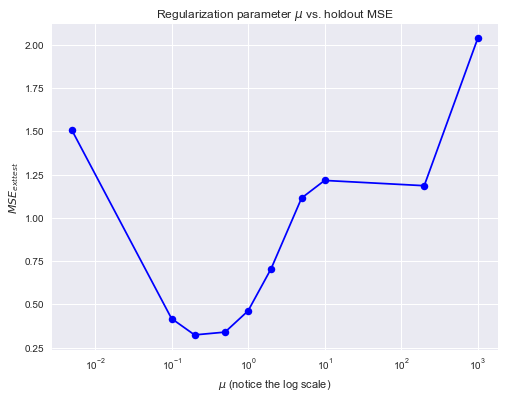

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.semilogx(mus, test_MSEs, "b.-", ms=15)
ax.set_xlabel("$\mu$ (notice the log scale)")
ax.set_ylabel("$MSE_{\text{test}}$")
ax.set_title("Regularization parameter $\mu$ vs. holdout MSE")

Notice that the holdout MSE has a u-shaped curve as a function of the regularization parameter

What you are seeing is that as $\mu \downarrow 0$ we approach the linear un-regularized case, which is pure linear regression

In this case the validation error will be quite large because the model is overfitting

As $\mu \uparrow \infty$ the model is being constrained to have very small weights and is underfitting

$\mu$ is a hyperparameter that needs to be chosen by a validation procedure

If we were choosing between the models indexed by our list of $\mu$ values and were applying the hold-out validation proceedure, we would choose the third model as our champion model.

In [10]:
print("The champion model has mu = {}".format(mus[2]))

The champion model has mu = 0.2


## Summary

- Ridge regression is an extension of linear regression with L2-regularization
- The objective function is: $MSE(\theta; x, y) + \mu \|\theta\|_2^2$
- As $\mu$ increases, the parameters are all *compressed* towards zero in absolute value
- If $\mu$ is small and model is overparameterized, overfitting may occur
- If $\mu$ is too large, underfitting will occur